# Plot solution corrections

The script evaluates the multiscale basis for the space $V^{\text{ms}'}_H$, and computes the system to find $w^n_x$ that solves

$$a(w^n_x, z) + \tau b(w^n_x, z) = a(w^{n-1}_x, z), \quad \forall z\in V^f,$$

for all $x\in \mathcal{N}_H$ and $n=1,2,...,N$ with $w^0_x = \lambda_x - \phi_x$. The finescale solution corrections $w^n_x$ is then plotted for a choice of $n$ and $x\in \mathcal{N}_H$. In this example the parameters are set as $1/h = 256$ and $1/H = 16$, and the coefficients are set as

$$A_\varepsilon(x) = (2 - \sin(2\pi x/\varepsilon_A)), \qquad B_\varepsilon(x) = (2 - \sin(2\pi x/\varepsilon_B))$$

with $\varepsilon_A = \varepsilon_B = 2^{-5}$.


In [1]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from gridlod import util, fem, coef, interp, linalg
from gridlod.world import World
import lod_wave

'''
Settings
'''

# fine mesh parameters
fine = 256
NFine = np.array([fine])
NpFine = np.prod(NFine + 1)
boundaryConditions = np.array([[0, 0]])
world = World(np.array([256]), NFine/np.array([256]), boundaryConditions)
NWorldFine = world.NWorldCoarse * world.NCoarseElement

# fine grid elements and nodes
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()

# time step parameters
tau = 0.01
numTimeSteps = 300

# ms coefficients
epsA = 2 ** (-5)
epsB = 2 ** (-5)
aFine = (2 - np.sin(2 * np.pi * xt / epsA)) ** (-1)
bFine = (2 - np.cos(2 * np.pi * xt / epsB)) ** (-1)

k_0 = np.inf
k_1 = np.inf
N = 16

# coarse mesh parameters
NWorldCoarse = np.array([N])
NCoarseElement = NFine / NWorldCoarse
world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

# grid nodes
xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
NpCoarse = np.prod(NWorldCoarse + 1)

'''
Compute multiscale basis
'''

# patch generator and coefficients
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse,
                                                              NCoarseElement, boundaryConditions)
b_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, bFine)
a_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, aFine / tau)

# compute basis correctors
lod = lod_wave.LodWave(b_coef, world, k_0, IPatchGenerator, a_coef)
lod.compute_basis_correctors()

# compute ms basis
basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
basis_correctors = lod.assembleBasisCorrectors()
ms_basis = basis - basis_correctors

'''
Compute finescale system

fs_solutions[i] = {w^i_x}_x
'''

prev_fs_sol = ms_basis
fs_solutions = []
for i in xrange(numTimeSteps):

    # solve system
    lod = lod_wave.LodWave(b_coef, world, k_1, IPatchGenerator, a_coef, prev_fs_sol, ms_basis)
    lod.solve_fs_system(localized=False)

    # store sparse solution
    prev_fs_sol = sparse.csc_matrix(np.array(np.column_stack(lod.fs_list)))
    fs_solutions.append(prev_fs_sol)


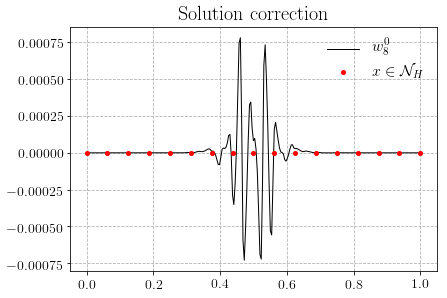

In [2]:
n = 0
x = N/2
plt.figure('Corr')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.subplots_adjust(left=0.14, bottom=0.07, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
plt.plot(xp, fs_solutions[n][:,x].todense(), 'k', label='$w^{%d}_{%d}$' %(n, x), linewidth=1)
plt.plot(xpCoarse, 0 * xpCoarse, 'or', label='$x\in \mathcal{N}_H$', markersize=4)
plt.title('Solution correction', fontsize=20)
plt.grid(True, which="both", ls="--")
plt.legend(frameon=False, fontsize=16)
plt.show()